# End-to-End PINN Training, Validation, and Testing

This notebook walks through data generation, model training, in-validation evaluation, and out-of-sample benchmarking for the Neural PDE Option Greeks project.

In [1]:
# 0) Environment
import os
import sys
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / 'src').exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / 'src').exists():
            PROJECT_ROOT = parent
            break
    else:
        raise RuntimeError("Could not locate project root containing 'src'.")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f'Project root: {PROJECT_ROOT}')
DATA_DIR = PROJECT_ROOT / 'data'
RESULTS_DIR = PROJECT_ROOT / 'results'
FIG_DIR = PROJECT_ROOT / 'figures' / 'end_to_end'
FIG_DIR.mkdir(parents=True, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device:', device)


Project root: /Users/amv10802/Documents/Neural-PDE-Option-Greeks
Using device: mps


In [2]:
# 1) Configuration
CONFIG = {
    'data': {
        'n_train': 100_000,
        'n_val':   20_000,
        'n_test':  20_000,
        'seed':    123,
    },
    'train': {
        'epochs': 50,
        'lr': 3e-4,              # higher LR so tanh nets make progress early
        'batch_size': 512,       # 512–1024 is a sweet spot; 512 is safer universally
        'adaptive_sampling': True,
        # delay adaptive until the base fit forms (≈ after epoch 12, 24, 36, 48)
        'adaptive_every': 12,
        'adaptive_points': 10_000,
        'adaptive_radius': 0.05,  # smaller radius in normalized space → less chaos
        'adaptive_eval_samples': 50_000,

        'use_warmup': True,
        'warmup_steps': 1000,    # longer warmup helps tanh avoid saturation early
        'grad_clip': 0.5,        # slightly tighter to prevent spikes with tanh
        'lambda_reg': 0.001,     # lighter Sobolev; tanh is already smooth
    }
}
CONFIG

{'data': {'n_train': 100000, 'n_val': 20000, 'n_test': 20000, 'seed': 123},
 'train': {'epochs': 50,
  'lr': 0.0003,
  'batch_size': 512,
  'adaptive_sampling': True,
  'adaptive_every': 12,
  'adaptive_points': 10000,
  'adaptive_radius': 0.05,
  'adaptive_eval_samples': 50000,
  'use_warmup': True,
  'warmup_steps': 1000,
  'grad_clip': 0.5,
  'lambda_reg': 0.001}}

In [3]:
# 2) Data generation (train/val/test)
from src.data import generate_dataset
splits = generate_dataset(
    n_train=CONFIG['data']['n_train'],
    n_val=CONFIG['data']['n_val'],
    n_test=CONFIG['data']['n_test'],
    seed=CONFIG['data']['seed'],
    output_dir=DATA_DIR,
)
list(splits.keys())

Generated datasets: train=100000, val=20000, test=20000


['train', 'val', 'test']

In [4]:
# 3) Train PINN
from src.train import train
checkpoint_path = RESULTS_DIR / 'pinn_checkpoint_e2e.pt'
plot_path = FIG_DIR / 'loss_curves.png'
log_path = RESULTS_DIR / 'training_history_e2e.json'
model, history = train(
    epochs=CONFIG['train']['epochs'],
    lr=CONFIG['train']['lr'],
    batch_size=CONFIG['train']['batch_size'],
    data_path=DATA_DIR / 'synthetic_train.npy',
    val_path=DATA_DIR / 'synthetic_val.npy',
    checkpoint_path=checkpoint_path,
    device=device,
    adaptive_sampling=CONFIG['train']['adaptive_sampling'],
    adaptive_every=CONFIG['train']['adaptive_every'],
    adaptive_points=CONFIG['train']['adaptive_points'],
    adaptive_radius=CONFIG['train']['adaptive_radius'],
    adaptive_eval_samples=CONFIG['train']['adaptive_eval_samples'],
    use_warmup=CONFIG['train']['use_warmup'],
    warmup_steps=CONFIG['train']['warmup_steps'],
    grad_clip=CONFIG['train']['grad_clip'],
    save_checkpoint=True,
    plot_losses=True,
    plot_path=plot_path,
    log_path=log_path,
    lambda_reg=CONFIG['train']['lambda_reg'],
)
history[-1] if history else 'Loaded existing checkpoint'


Epoch 001 | loss=1813.246341 | price=1808.332630 | pde=4.913693 | reg=0.000025
Epoch 002 | loss=1297.532085 | price=1291.443810 | pde=6.088271 | reg=0.000035
Epoch 003 | loss=1109.518605 | price=1098.715569 | pde=10.803023 | reg=0.000043
Epoch 004 | loss=965.261202 | price=947.100845 | pde=18.160310 | reg=0.000056
Epoch 005 | loss=900.245028 | price=879.907774 | pde=20.337193 | reg=0.000064
Epoch 006 | loss=854.851123 | price=830.932649 | pde=23.918411 | reg=0.000071
Epoch 007 | loss=820.694719 | price=794.646238 | pde=26.048415 | reg=0.000076
Epoch 008 | loss=781.526060 | price=754.689199 | pde=26.836795 | reg=0.000079
Epoch 009 | loss=746.816343 | price=719.542324 | pde=27.273945 | reg=0.000086
Epoch 010 | loss=707.292404 | price=679.479629 | pde=27.812687 | reg=0.000092
Epoch 011 | loss=665.943333 | price=637.051450 | pde=28.891776 | reg=0.000100
Epoch 012 | loss=621.053887 | price=592.078953 | pde=28.974819 | reg=0.000108
Epoch 013 | loss=600.150864 | price=568.016403 | pde=32.1343

{'epoch': 50,
 'loss': 6.153927227658947,
 'price': 3.5356956218933537,
 'pde': 2.6176705624717864,
 'reg': 0.000561048634359647,
 'lr': 0.0003,
 'val_loss': 7.059255886077881,
 'val_price': 3.560855042934418,
 'val_pde': 3.4978781282901763,
 'val_reg': 0.0005227307861787267}

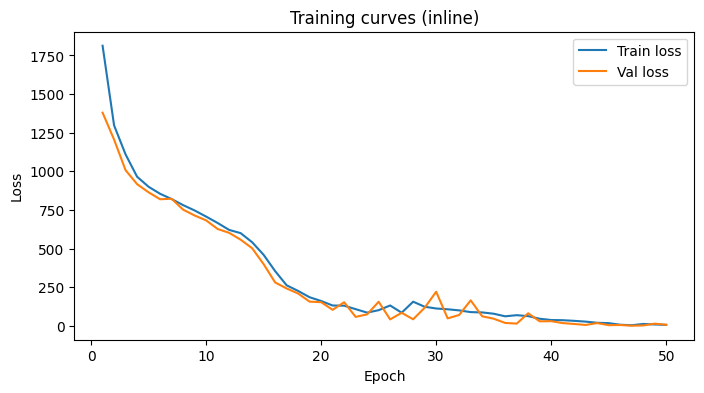

In [5]:
# 4) Plot training curves inline
if history:
    epochs = [entry['epoch'] for entry in history]
    plt.figure(figsize=(8,4))
    plt.plot(epochs, [entry['loss'] for entry in history], label='Train loss')
    if 'val_loss' in history[0]:
        plt.plot(epochs, [entry['val_loss'] for entry in history], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training curves (inline)')
    plt.legend()
    plt.show()
else:
    from pathlib import Path
    display(Path(plot_path))

In [6]:
# 5) Validation metrics on synthetic_val
from src.preprocessing import normalize_inputs
from src.utils.black_scholes import bs_greeks
val = np.load(DATA_DIR / 'synthetic_val.npy')
subset = val if len(val) <= 20000 else val[np.random.choice(len(val), 20000, replace=False)]
S_np, t_np, sigma_np, price_np = subset.T
S = torch.tensor(S_np, dtype=torch.float32, device=device, requires_grad=True)
t = torch.tensor(t_np, dtype=torch.float32, device=device, requires_grad=True)
sigma = torch.tensor(sigma_np, dtype=torch.float32, device=device)
features = normalize_inputs(S, t, sigma)
model.eval()
pred = model(features).squeeze()
delta = torch.autograd.grad(pred, S, torch.ones_like(pred), create_graph=True)[0]
gamma = torch.autograd.grad(delta, S, torch.ones_like(delta), create_graph=False)[0]
with torch.no_grad():
    pred_np = pred.detach().cpu().numpy()
    delta_np = delta.detach().cpu().numpy()
    gamma_np = gamma.detach().cpu().numpy()
analytic = bs_greeks(S_np, 100.0, 2.0, t_np, sigma_np, 0.05)
price_rmse = float(np.sqrt(np.mean((pred_np - price_np) ** 2)))
delta_mae = float(np.mean(np.abs(delta_np - analytic['delta'])))
gamma_mae = float(np.mean(np.abs(gamma_np - analytic['gamma'])))
{ 'price_rmse': price_rmse, 'delta_mae': delta_mae, 'gamma_mae': gamma_mae }

{'price_rmse': 1.8876387218745374,
 'delta_mae': 0.024486465443741428,
 'gamma_mae': 0.0017594683711053506}

In [7]:
# 6) Out-of-sample evaluation & visuals
from src.test import evaluate_oos
oos_metrics = evaluate_oos(
    data_path=DATA_DIR / 'synthetic_test.npy',
    model_path=checkpoint_path,
    device=device,
    sample_size=20000,
    mc_paths=50_000,
    seed=42,
    fig_dir=FIG_DIR / 'oos',
    surface_grid=40,
)
oos_metrics

{'pinn_price_rmse': 1.8646410763746109,
 'pinn_delta_mae': 0.024296742784140197,
 'pinn_gamma_mae': 0.0017384329997242687,
 'fd_delta_mae': 4.9847815269093156e-09,
 'fd_gamma_mae': 5.720450340386867e-10,
 'mc_delta_mae': 0.07079613289692539}

### Training History (JSON excerpt)

[{'epoch': 48,
  'loss': 12.187939315095662,
  'price': 7.583522582148004,
  'pde': 4.60387025967123,
  'reg': 0.0005463834519234053,
  'lr': 0.0003,
  'val_loss': 2.6483268678188323,
  'val_price': 2.379765683412552,
  'val_pde': 0.26805262695997956,
  'val_reg': 0.0005085395379865077},
 {'epoch': 49,
  'loss': 8.960019820362982,
  'price': 5.224505114511852,
  'pde': 3.7349546608807396,
  'reg': 0.0005600351557079499,
  'lr': 0.0003,
  'val_loss': 14.026134872436524,
  'val_price': 6.944941306114197,
  'val_pde': 7.0807284116744995,
  'val_reg': 0.00046507134902640246},
 {'epoch': 50,
  'loss': 6.153927227658947,
  'price': 3.5356956218933537,
  'pde': 2.6176705624717864,
  'reg': 0.000561048634359647,
  'lr': 0.0003,
  'val_loss': 7.059255886077881,
  'val_price': 3.560855042934418,
  'val_pde': 3.4978781282901763,
  'val_reg': 0.0005227307861787267}]

### Saved Loss Curves

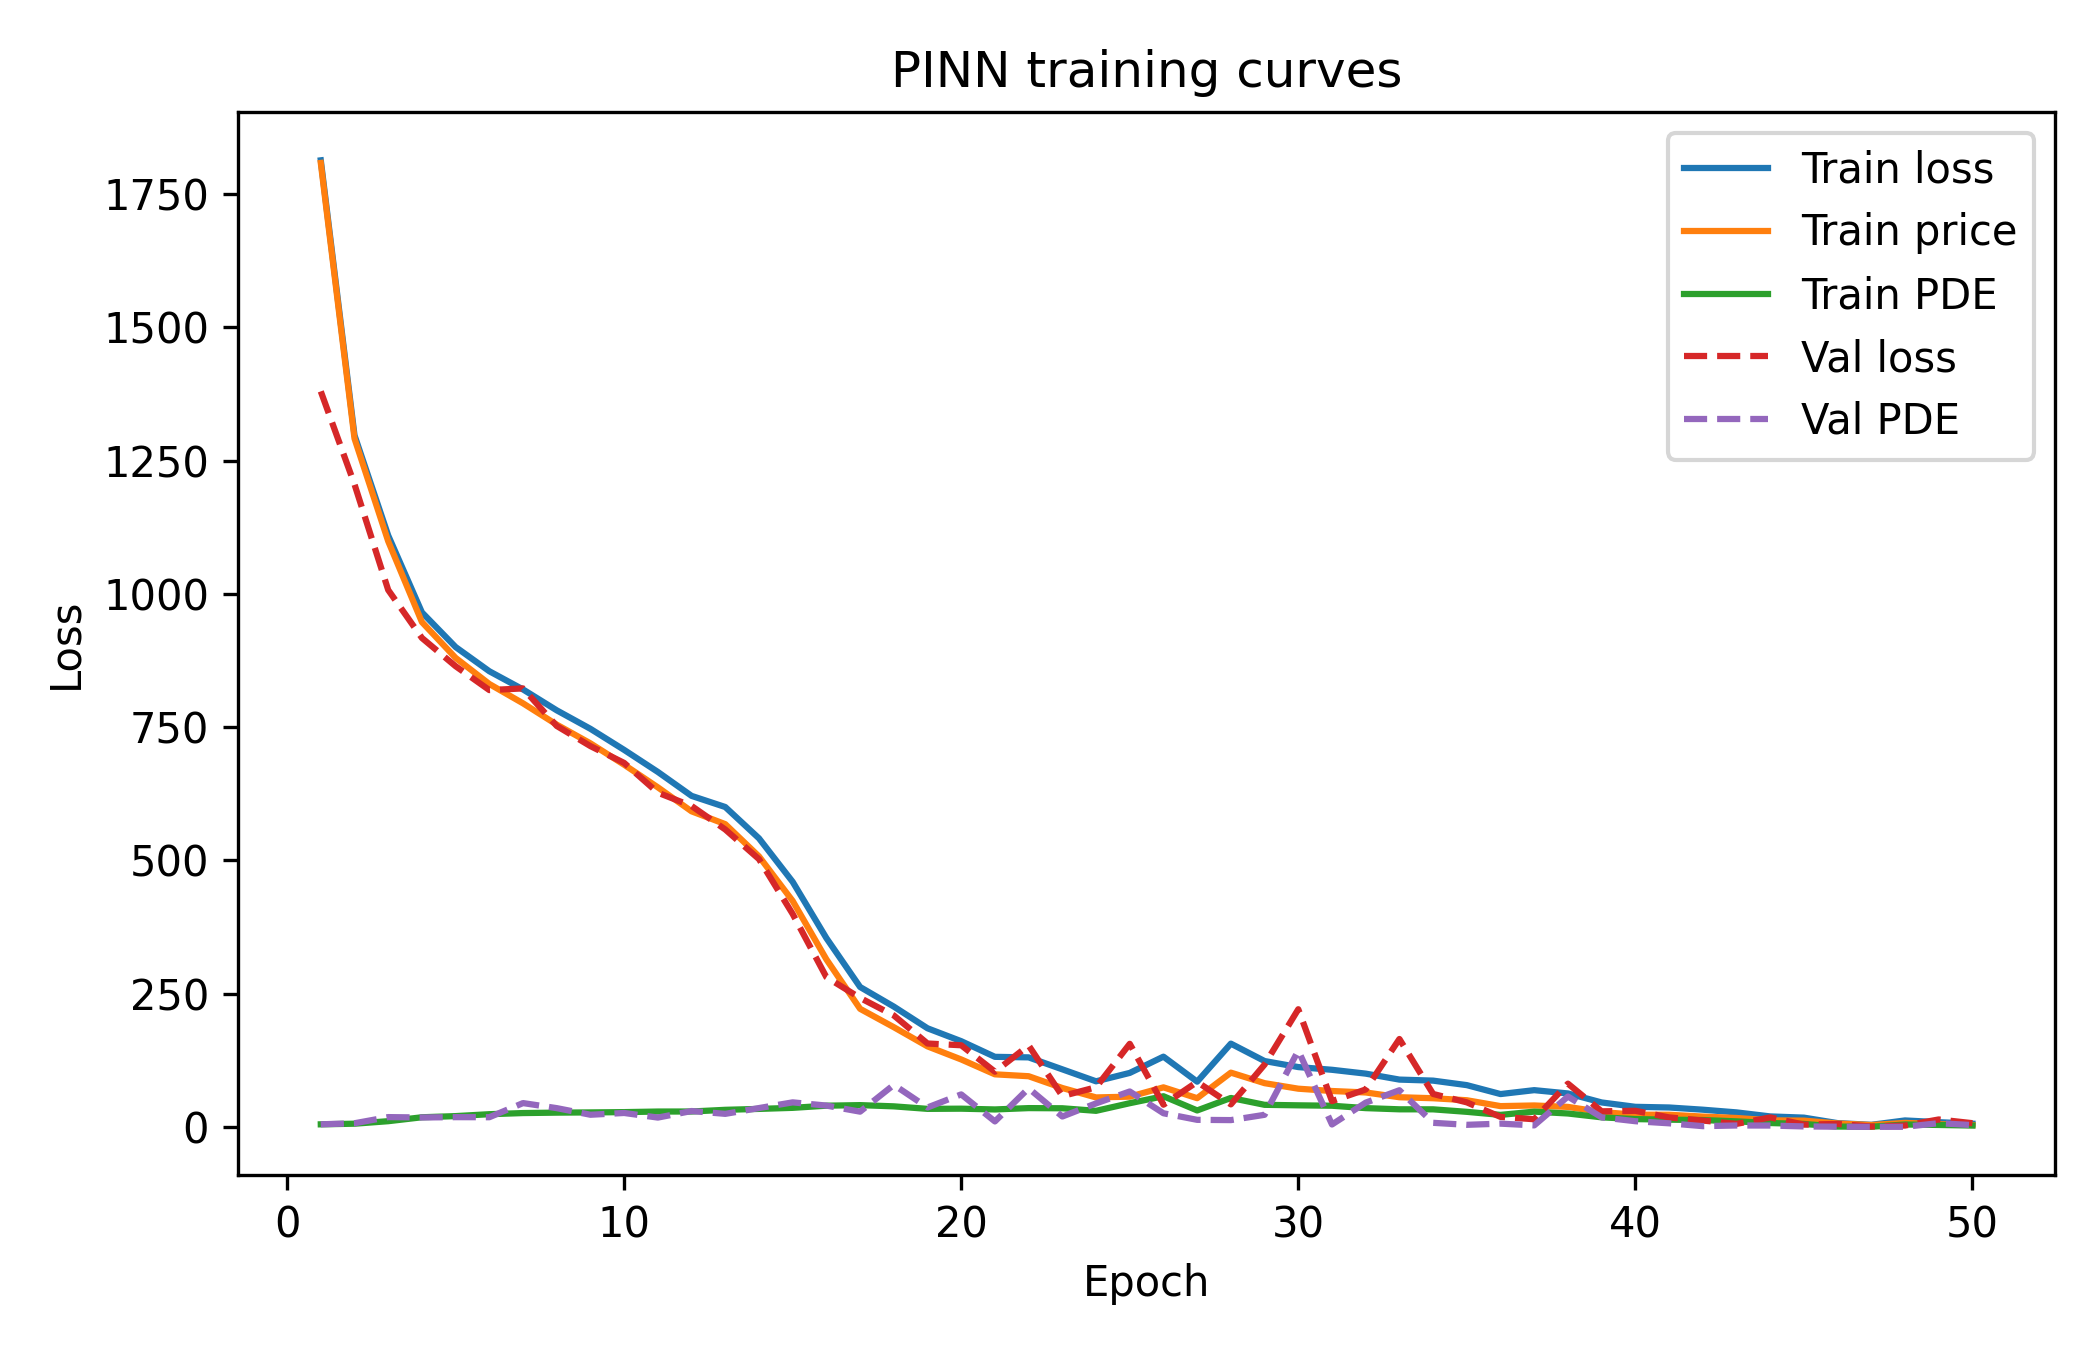

### Out-of-Sample Figures

**analytic_surface.png**

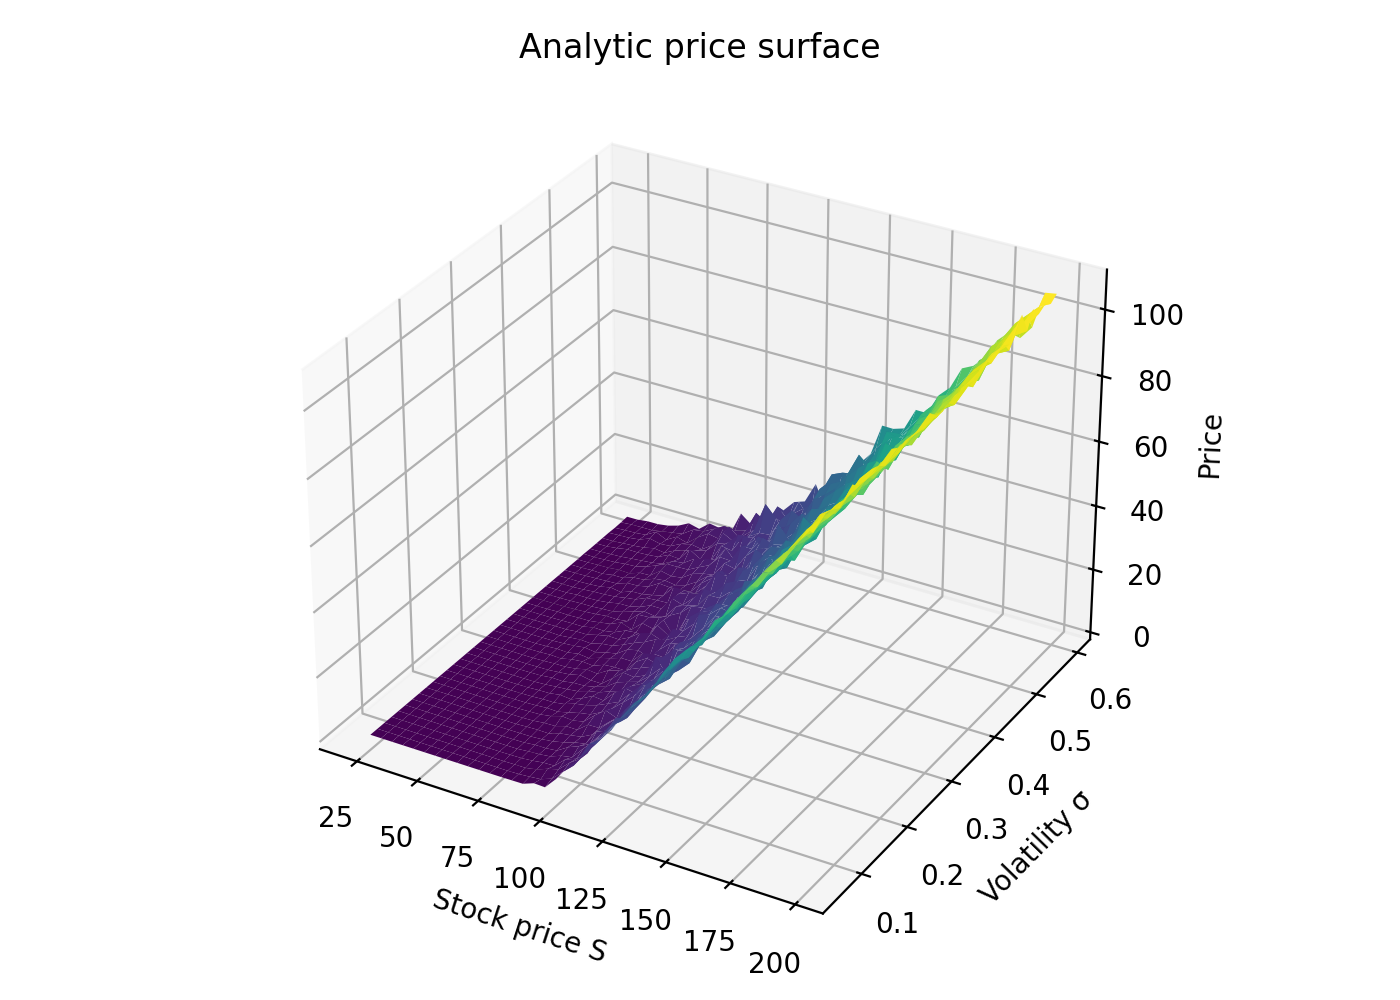

**oos_summary.png**

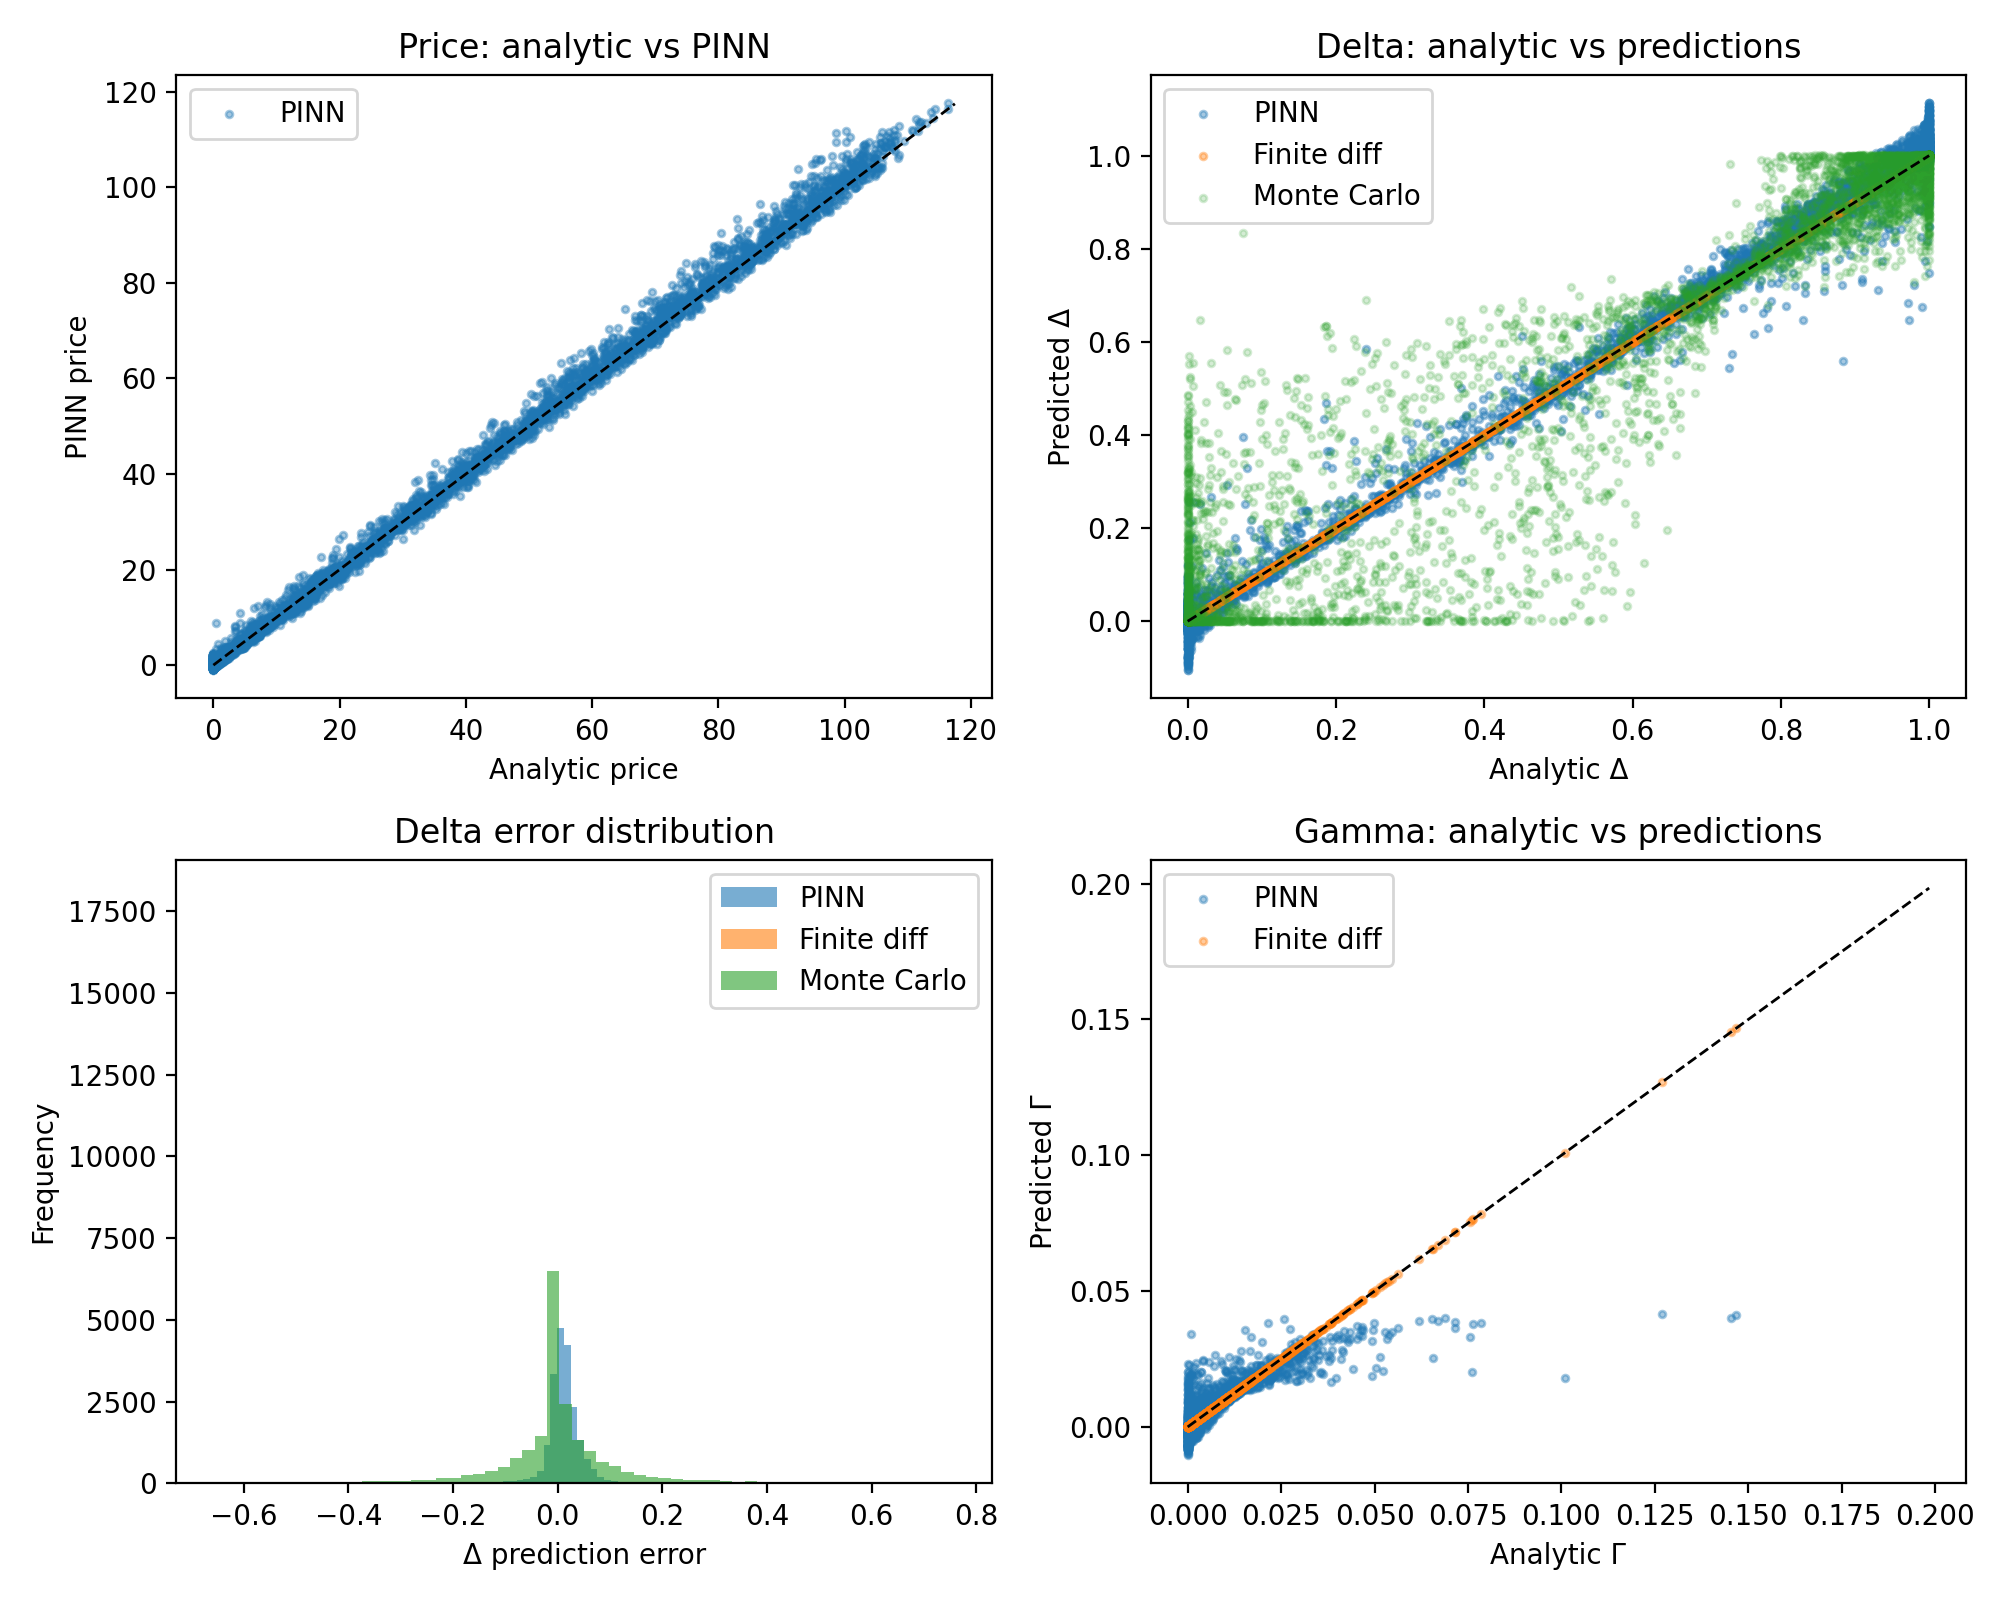

**pinn_surface.png**

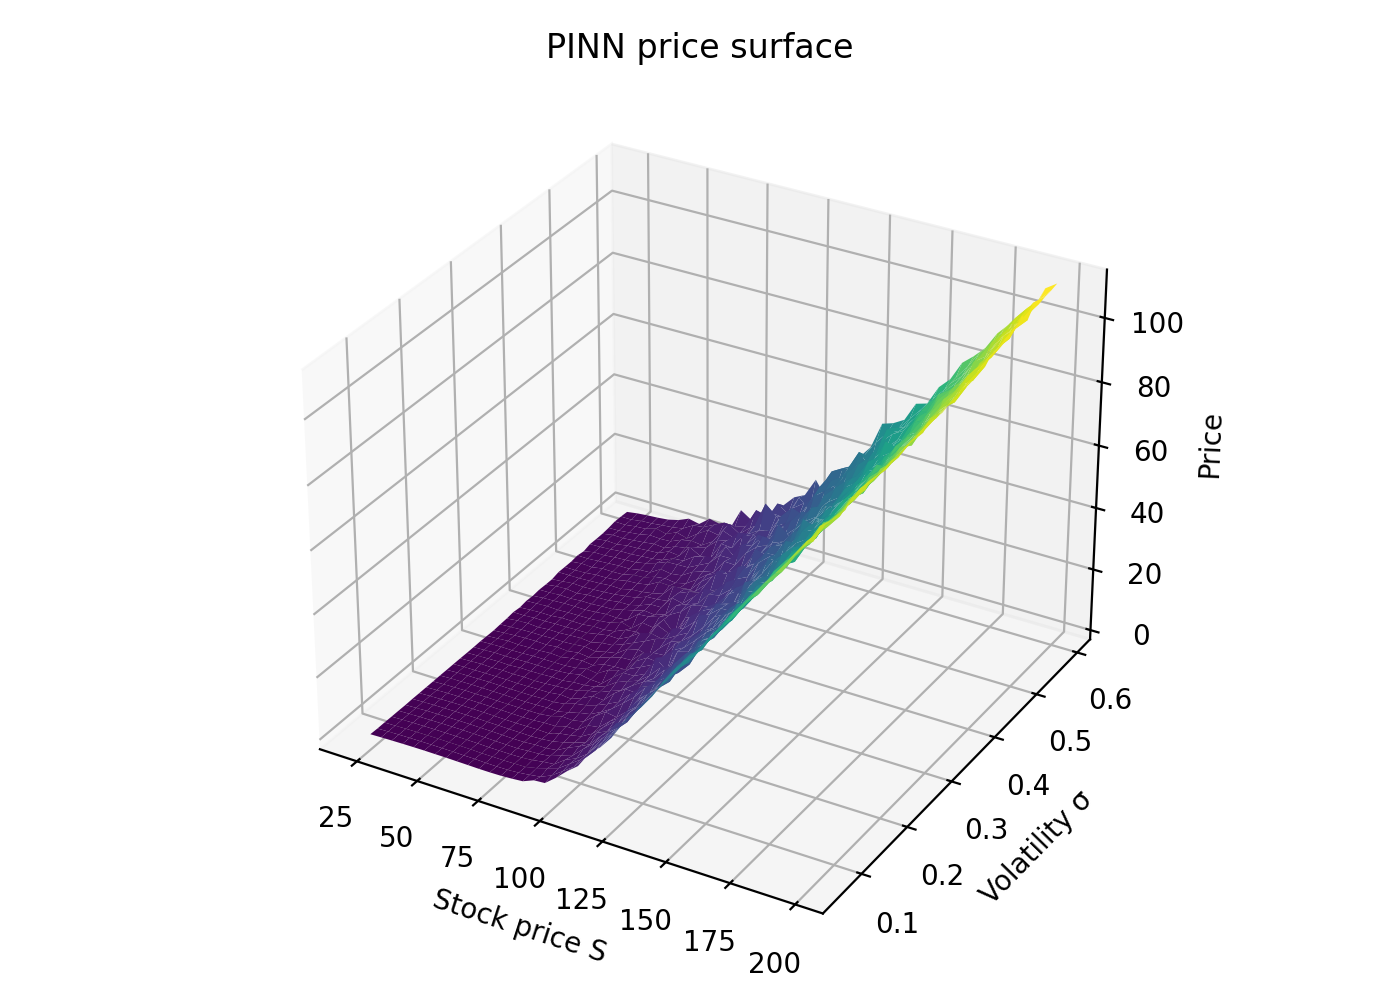

**price_error_surface.png**

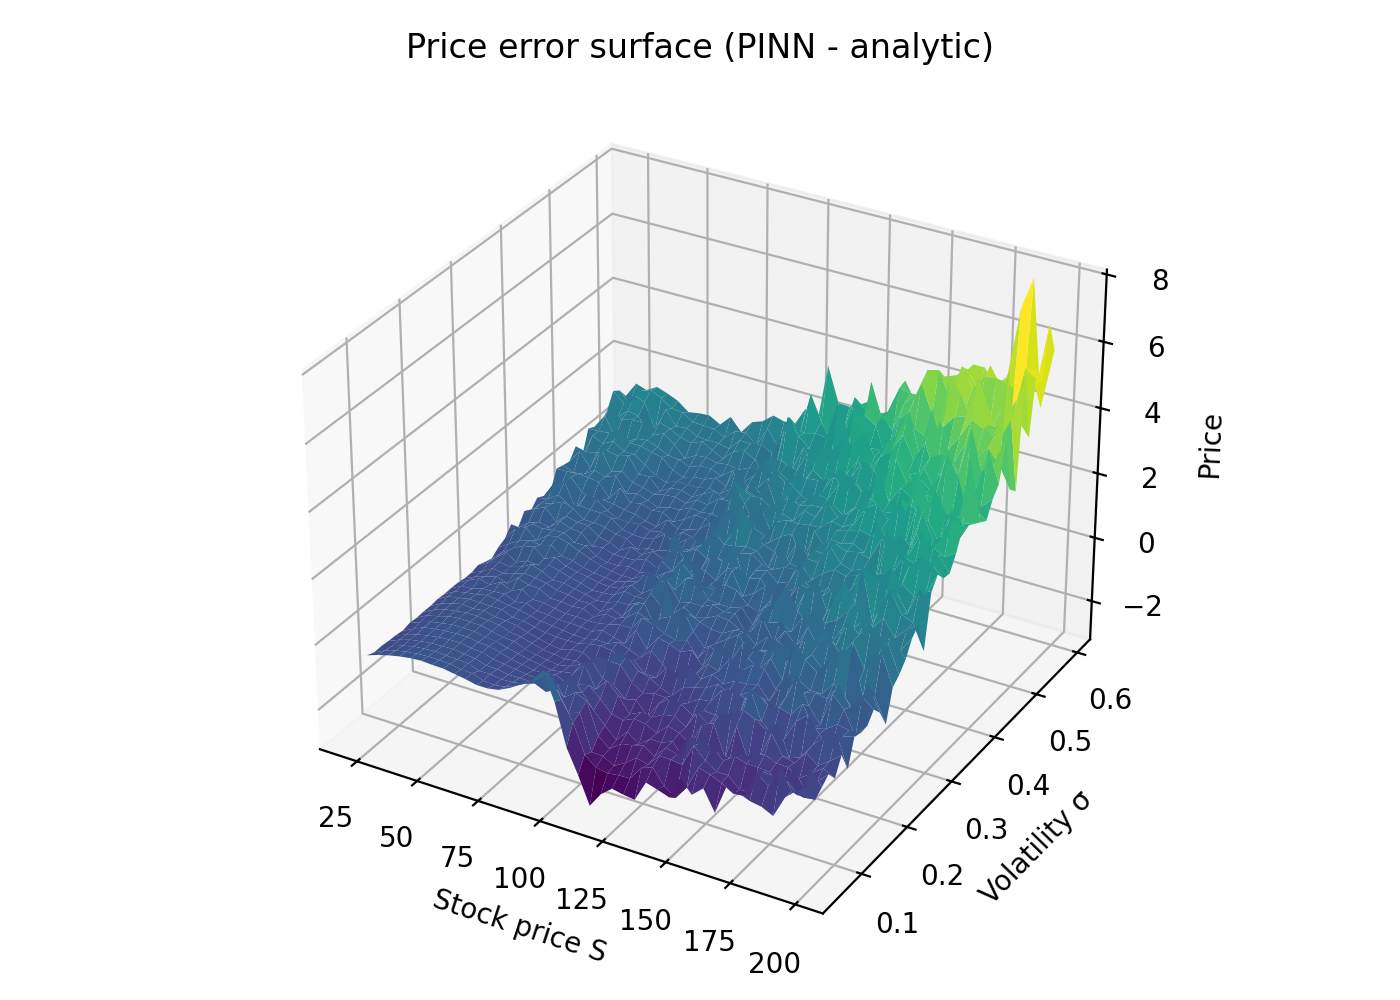

**price_error_vs_S.png**

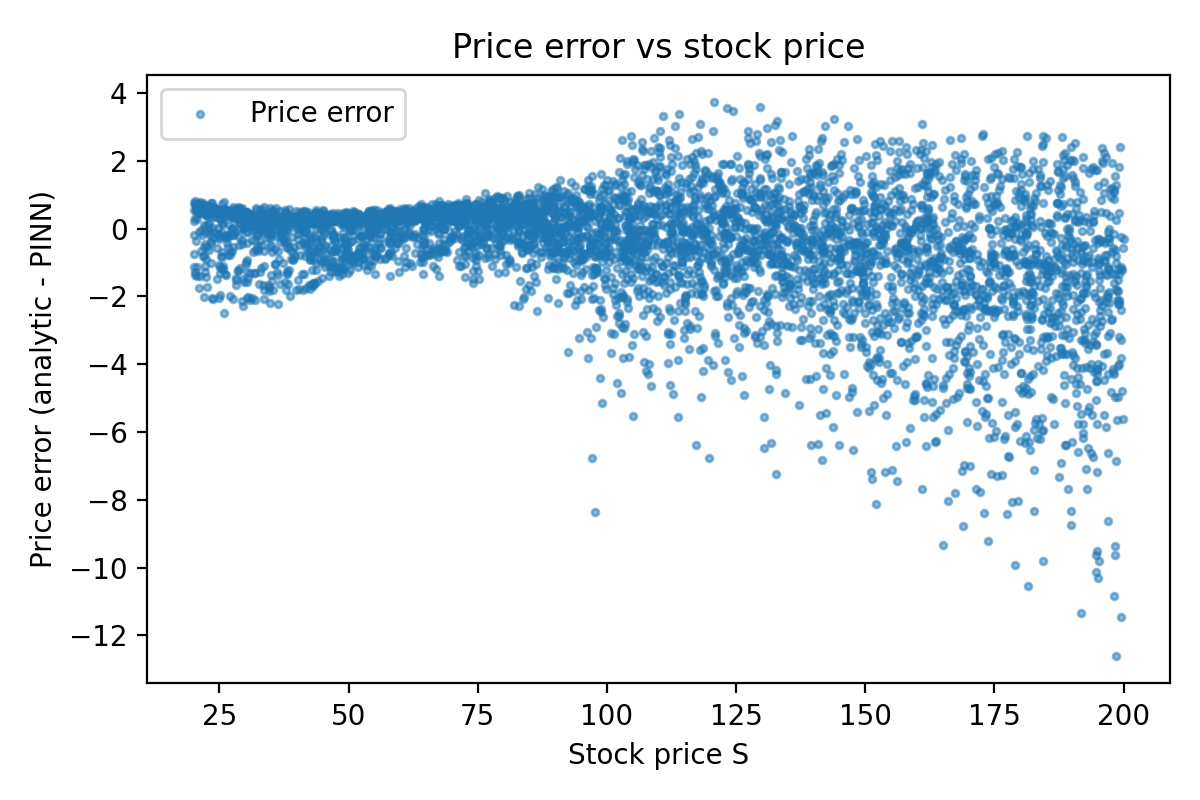

### Latest OOS Metrics

{'pinn_price_rmse': 5.164697402905392,
 'pinn_delta_mae': 0.07579705057152884,
 'pinn_gamma_mae': 0.010945802257289871,
 'fd_delta_mae': 4.8131807287042595e-09,
 'fd_gamma_mae': 3.5426855190994024e-10,
 'mc_delta_mae': 0.06710662214968789}

In [8]:
# 7) Browse generated artifacts
from IPython.display import display, Markdown, Image
import json

display(Markdown('### Training History (JSON excerpt)'))
history_path = RESULTS_DIR / 'training_history_e2e.json'
if history_path.exists():
    with open(history_path) as fp:
        hist = json.load(fp)
    display(hist[-3:])
else:
    print('No training history found.')

display(Markdown('### Saved Loss Curves'))
loss_plot = FIG_DIR / 'loss_curves.png'
if loss_plot.exists():
    display(Image(filename=str(loss_plot)))
else:
    print('Loss curve plot not found.')

display(Markdown('### Out-of-Sample Figures'))
oos_dir = FIG_DIR / 'oos'
if oos_dir.exists():
    for img in sorted(oos_dir.glob('*.png')):
        display(Markdown(f'**{img.name}**'))
        display(Image(filename=str(img)))
else:
    print('No OOS figures found.')

display(Markdown('### Latest OOS Metrics'))
oos_metrics_path = RESULTS_DIR / 'oos_metrics.json'
if oos_metrics_path.exists():
    with open(oos_metrics_path) as fp:
        display(json.load(fp))
else:
    print('OOS metrics JSON not found.')


## Summary
- Regularization strength (lambda) used: `CONFIG['train']['lambda_reg']`
- Training history saved to `results/training_history_e2e.json` and plots inside `figures/end_to_end/`.
- Validation metrics computed on the hold-out validation split.
- Out-of-sample metrics and comparison plots written under `results/oos_metrics.json` and `figures/end_to_end/oos/`.